## 输入库

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import shutil
import matplotlib.gridspec as gridspec

## 功能函数

### 傅里叶变换

In [2]:
def f2fk(f,NumK):
  NumX = f.shape[0]
  fk_ex = np.fft.ifft(f, axis=0)
  fk = np.conj(fk_ex[:NumK,:])
  return fk

def fk2f(fk,NumX):
  NumK,NumV = fk.shape
  fk_ex = np.zeros((NumX,NumV), dtype=complex)
  fk_ex[:NumK,:] = fk*NumX
  fk_ex[-1:-NumK:-1,:] = np.conj((fk[1:NumK,:])*NumX)
  f = np.real(np.fft.ifft(fk_ex, axis=0))
  return f

### 未扰动演化

In [3]:
def Upd(PreOrCor,UpdPhase,dfk0):
  dfk = dfk0*UpdPhase[:,:,PreOrCor]
  return(dfk)

### 拉回变换

In [4]:
def PullBack(FlagNL,PreOrCor,phikT,Gkx_phik,Gkv_phik,dvF0,dfk,k,hv):
  n = 1 if PreOrCor else 0

  Gkv = Gkv_phik[:,:,n]*phikT

  if not FlagNL:
    dfk += Gkv*dvF0
  else:
    Gkx = Gkx_phik[:,:,n]*phikT

    Gx = fk2f(Gkx,Nx)
    Gv = fk2f(Gkv,Nx)

    'Nonlinear Terms dfa = G*d(df+F0)'
    dfkdx = 1j*k*dfk
    dfkdv = np.zeros_like(dfk)
    dfkdv[:,0] = (dfk[:,1]-dfk[:,0])*hv
    dfkdv[:,1:-1] = (dfk[:,2:]-dfk[:,:-2])*0.5*hv
    dfkdv[:,-1] = (dfk[:,-1]-dfk[:,-2])*hv
    dfkdv[0,:] += dvF0[0,:]
    dfdx = fk2f(dfkdx,Nx)
    dfdv = fk2f(dfkdv,Nx)
    dfa = Gx*dfdx + Gv*dfdv
    dfka = f2fk(dfa,Nk)
    
    'Nonlinear Terms dfa = G*d(G*d(F0+df))'
    dfkdx = 1j*k*dfka
    dfkdv[:,0] = (dfka[:,1]-dfka[:,0])*hv
    dfkdv[:,1:-1] = (dfka[:,2:]-dfka[:,:-2])*0.5*hv
    dfkdv[:,-1] = (dfka[:,-1]-dfka[:,-2])*hv
    dfdx = fk2f(dfkdx,Nx)
    dfdv = fk2f(dfkdv,Nx)
    dfb = 0.5*(Gx*dfdx + Gv*dfdv)
    dfkb = f2fk(dfb,Nk)

    dfk += dfka + dfkb
  return(dfk)

### 场方程

In [5]:
def Field(dfk,e,k,dv,eps):
  dNek = np.sum(dfk,axis=1).reshape(-1,1)*dv
  phik = np.where( k < 0.1*k[1,0],
    0.0,
    e*dNek/(eps*k*k))
  return(phik)

### 诊断

In [6]:
def Diagnoses(t,phik,dfk,k0):
  with open('Output/TimeList.dat','a') as file:
    file.write(f'{t}\n')

  phi = fk2f(phik,Nx)
  #ene = 0.5*eps*np.sum(phi**2)*dx
  ene = np.sum(np.abs(phik)**2)*np.pi/k0
  with open('Output/energy.dat','a') as file:
    file.write(f'{ene}\n')

  with open('Output/phi.dat', 'ab') as f:
    phi.tofile(f)
  with open('Output/phik.dat', 'ab') as f:
    abs(phik).tofile(f)
  with open('Output/fa.dat', 'ab') as f:
    abs(dfk[0,:]).tofile(f)

## 初始化

### 设置输入参数

In [7]:
m   =  1.0
e   = -1.0
n   =  1.0
tem =  1.0

FlagPhi0 = False
FlagPhi1 = True
FlagNL   = True

TotalTime = 200.0
dt        = 0.1
nDiag     = 500
MaxStep   = 20000

Nk   = 32
Nv   = 513
vMax = 6.0

phi0A      = 0.0
phi0Lambda = 10.0
k0         = 0.4
delta      = 0.05

### 初始化——全局信息

定义物理常数

In [8]:
m0       = 9.1094e-31       # kg
e0       = 1.6021892e-19    # C
n0       = 1.0e19           # m^-3
tem0     = 1.0              # keV
epsilon0 = 8.854187817e-12  # F/m
B0       = 1.0              # T
mp       = 1.6726485e-27    # kg

初始化归一

In [9]:
mRef = m0
eRef = e0
nRef = n0
temRef = tem0*1000.0*e0

vRef = np.sqrt(temRef/mRef)
tRef = np.sqrt(epsilon0*mRef/(nRef*eRef*eRef))
xRef = vRef*tRef

初始化扰动

In [10]:
phi0A = phi0A*1000.0*e0/temRef
#k0 = 2.0*np.pi*xRef/phi0Lambda
#k0 = 0.4

cPhi0 = 1.0 if FlagPhi0 else 0.0
cPhi1 = 1.0 if FlagPhi1 else 0.0
FlagCor = False

em = e/m
eps = 1.0

初始化网格

In [11]:
k = np.arange(Nk).reshape(-1,1)*k0

Nx = 4*Nk
NkF = Nx/2 + 1
dx = 2.0*np.pi/(k0*Nx)
x = np.arange(Nx).reshape(-1,1)*dx

dv = 2.0*vMax/(Nv-1)
hv = 1.0/dv
v = np.arange(Nv).reshape(1,-1)*dv - vMax

初始化$F_0$

In [12]:
F0 = np.sqrt(m/(2.0*np.pi*tem))*np.exp(-0.5*m*v**2/tem)

dvF0 = np.zeros_like(F0)
dvF0[0,0] = (F0[0,1]-F0[0,0])*hv
dvF0[0,1:-1] = (F0[0,2:]-F0[0,:-2])*0.5*hv
dvF0[0,-1] = (F0[0,-1]-F0[0,-2])*hv

初始化$\phi_0$

In [13]:
phi0k = np.zeros_like(k)
phi0k[1,0] = 0.5*phi0A
phi0 = fk2f(phi0k,Nx)

输出$\phi_0\left(x\right)$

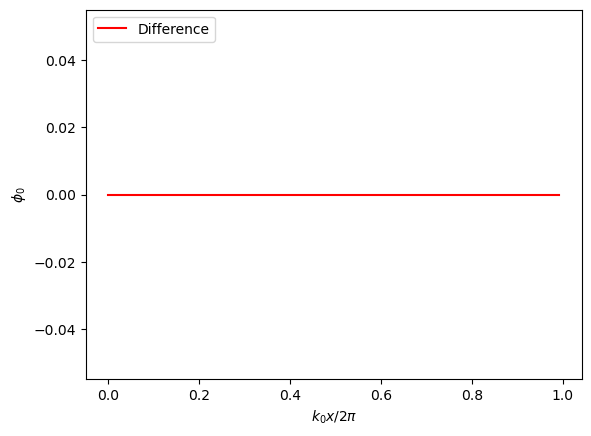

In [15]:
fig, ax1 = plt.subplots()
ax1.plot(k0*x/(2.0*np.pi),phi0,color='red',label='Difference')
ax1.set_xlabel('$k_0 x / 2\\pi$',color='black')
ax1.set_ylabel('$\\phi_0$',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')

### 初始化——扰动分布

初始化$\delta f_k$

In [16]:
dfk  = np.zeros((Nk,Nv))
dfk[1,:] = delta*0.5*F0
dfk0 = np.zeros_like(dfk)

phik = np.zeros_like(k)
phi = np.zeros_like(x)

### 初始化——未扰动演化信息

In [17]:
k_ex = k[:,:,np.newaxis]
v_ex = v[:,:,np.newaxis]
dtc = np.arange(1,3).reshape(1,1,2)*0.5*dt

UpdPhase = np.exp(-1j*k_ex*v_ex*dtc)

In [18]:
condition = np.abs(k_ex*v_ex) < 0.1*dv

Gkv_phik = np.where(condition,
        em*1j*k_ex*np.ones_like(v_ex)*dtc,
        em*(1.0-np.exp(-1j*k_ex*v_ex*dtc))/v_ex)
Gkx_phik = np.where(condition,
        0.5*Gkv_phik*dtc,
        Gkv_phik/(1j*k_ex*v_ex)-em*dtc*np.exp(-1j*k_ex*v_ex*dtc)/v_ex)

#del k_ex,v_ex,dtc,condition

C:\Users\liang\AppData\Local\Temp\ipykernel_14432\1572960961.py:5: RuntimeWarning: invalid value encountered in divide
  em*(1.0-np.exp(-1j*k_ex*v_ex*dtc))/v_ex)
C:\Users\liang\AppData\Local\Temp\ipykernel_14432\1572960961.py:8: RuntimeWarning: divide by zero encountered in divide
  Gkv_phik/(1j*k_ex*v_ex)-em*dtc*np.exp(-1j*k_ex*v_ex*dtc)/v_ex)
C:\Users\liang\AppData\Local\Temp\ipykernel_14432\1572960961.py:8: RuntimeWarning: invalid value encountered in divide
  Gkv_phik/(1j*k_ex*v_ex)-em*dtc*np.exp(-1j*k_ex*v_ex*dtc)/v_ex)


### 初始化——诊断

In [19]:
DiagTime = TotalTime/nDiag

output_folder = 'Output'
if os.path.exists(output_folder):
  shutil.rmtree(output_folder)
os.makedirs(output_folder)


np.savetxt('Output/Normalization.dat', 
    [mRef,eRef,tRef,vRef,xRef,k0,TotalTime,dt])

k.tofile('Output/k.bin')
x.tofile('Output/x.bin')
v.tofile('Output/v.bin')
F0.tofile('Output/F0.bin')
phi0.tofile('Output/Phi0.bin')
phi0k.tofile('Output/Phi0k.bin')

## 第0步计算

In [20]:
'时间'
t = 0.0
tStep = 0

'场方程'
phik = Field(dfk,e,k,dv,eps)
phi = fk2f(phik,Nx)

'诊断'
Diagnoses(t,phik,dfk,k0)

C:\Users\liang\AppData\Local\Temp\ipykernel_14432\4228897554.py:5: RuntimeWarning: invalid value encountered in divide
  e*dNek/(eps*k*k))


Plot输出

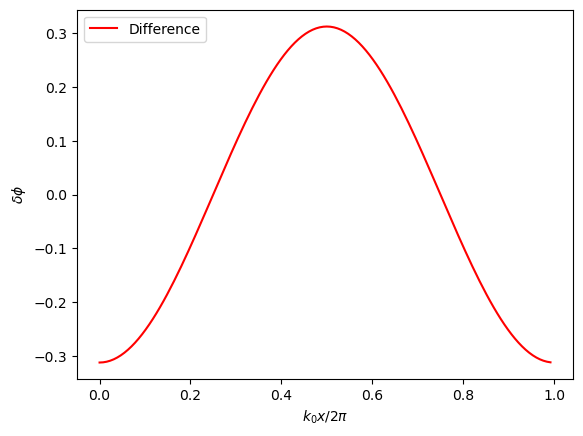

In [22]:
fig, ax1 = plt.subplots()
ax1.plot(k0*x/(2.0*np.pi),phi,color='red',label='Difference')
ax1.set_xlabel('$k_0 x / 2\\pi$',color='black')
ax1.set_ylabel('$\\delta\\phi$',color='black')
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper left')

## 主循环

In [23]:
NotePst = 10.0  # 5%
NoteTime = TotalTime*0.01*NotePst

STime = time.perf_counter()
while t < TotalTime-0.1*dt:
  t += dt
  tStep += 1

  'Prediction'
  if FlagNL:
    PreOrCor = 0
    dfk0 = dfk
    dfk = Upd(PreOrCor,UpdPhase,dfk0)
    dfk = PullBack(FlagNL,PreOrCor,phik,Gkx_phik,Gkv_phik,dvF0,dfk,k,hv)
    phik = Field(dfk,e,k,dv,eps)
  
  'Correction'
  PreOrCor = 1
  if not FlagNL:
    dfk0 = dfk
  dfk = Upd(PreOrCor,UpdPhase,dfk0)
  dfk = PullBack(FlagNL,PreOrCor,phik,Gkx_phik,Gkv_phik,dvF0,dfk,k,hv)
  phik = Field(dfk,e,k,dv,eps)

  if abs(round(t/DiagTime)*DiagTime-t) <= 0.1*dt:
    Diagnoses(t,phik,dfk,k0)

  if abs(round(t/NoteTime)*NoteTime-t) <= 0.1*dt:
    ETime = time.perf_counter()
    task_completion = round(t/NoteTime)*NotePst
    print(f'Task has run {task_completion}%, '
          f'this {NotePst}% is used {ETime-STime:.3f} seconds.')
    STime = ETime

C:\Users\liang\AppData\Local\Temp\ipykernel_14432\4228897554.py:5: RuntimeWarning: divide by zero encountered in divide
  e*dNek/(eps*k*k))
C:\Users\liang\AppData\Local\Temp\ipykernel_14432\4228897554.py:5: RuntimeWarning: invalid value encountered in divide
  e*dNek/(eps*k*k))


Task has run 10.0%, this 10.0% is used 5.006 seconds.
Task has run 20.0%, this 10.0% is used 4.123 seconds.
Task has run 30.0%, this 10.0% is used 4.985 seconds.
Task has run 40.0%, this 10.0% is used 4.693 seconds.
Task has run 50.0%, this 10.0% is used 4.603 seconds.
Task has run 60.0%, this 10.0% is used 4.439 seconds.
Task has run 70.0%, this 10.0% is used 4.382 seconds.
Task has run 80.0%, this 10.0% is used 5.114 seconds.
Task has run 90.0%, this 10.0% is used 4.976 seconds.
Task has run 100.0%, this 10.0% is used 4.619 seconds.


## 输出

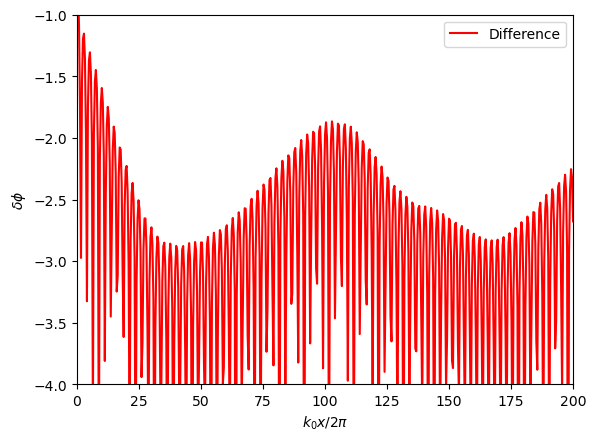

In [24]:
t = np.loadtxt('Output/TimeList.dat')
ene = np.loadtxt('Output/energy.dat')

fig, ax1 = plt.subplots()
ax1.plot(t,np.log10(ene),color='red',label='Difference')
ax1.set_xlabel('$k_0 x / 2\\pi$',color='black')
ax1.set_ylabel('$\\delta\\phi$',color='black')
ax1.set_xlim(0, TotalTime)
ax1.set_ylim(-4, -1)
ax1.tick_params(axis='y', color='black')
ax1.legend(loc = 'upper right')

#plt.savefig('Nonlinear.jpg', format='jpg')
#plt.show()